## Week 4: 

### Problem 1:

#### (a)

Summary statistics:
Mean: 720.277975327 
Median: 172.21 
Maximum: 227967.25 
Minimum: 0.01 
Standard deviation: 3972.66375639


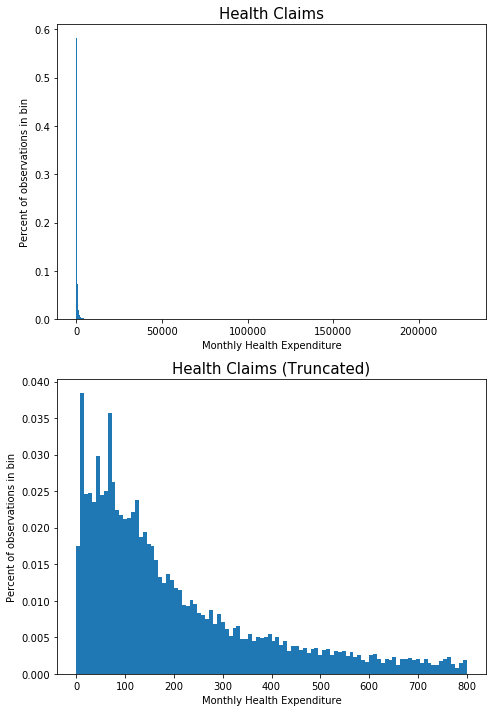

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt


clms = np.loadtxt('clms.txt')
clms_mean = np.mean(clms)
clms_median = np.median(clms)
clms_std = np.std(clms)
clms_min = np.amin(clms)
clms_max = np.amax(clms)
print("Summary statistics:\nMean:", clms_mean,
      "\nMedian:", clms_median,
      "\nMaximum:", clms_max,
      "\nMinimum:", clms_min,
      "\nStandard deviation:", clms_std)

plt.figure(figsize=(7,10))
plt.subplot(211)
num_bins = 1000
weights = (1 / clms.shape[0]) * np.ones_like(clms)
n, bin_cuts, patches = plt.hist(clms, num_bins, weights=weights)
plt.title('Health Claims', fontsize=15)
plt.xlabel('Monthly Health Expenditure')
plt.ylabel('Percent of observations in bin')

plt.subplot(212)
num_bins = 100
clms_trunc = clms[clms<800]
weights = (1 / clms.shape[0]) * np.ones_like(clms_trunc)
n, bin_cuts, patches = plt.hist(clms_trunc, num_bins, weights=weights)
plt.title('Health Claims (Truncated)', fontsize=15)
plt.xlabel('Monthly Health Expenditure')
plt.ylabel('Percent of observations in bin')

plt.tight_layout()
plt.show()

The second figure is clearly preferable to the first – the most interesting "action" in the data is at the lower end of the distribution, but there's an extremely long right hand tail that renders a full histogram practically meaningless.

#### (b) Gamma MLE

In [2]:
import math

def gamma_pdf(xvals, alpha, beta):
    denom = (beta ** alpha) * math.gamma(alpha)
    a = (xvals ** (alpha - 1))
    b = np.exp((-1)* xvals / beta)
    numer = a * b
    pdf_vals = numer / denom
    
    return pdf_vals

def log_lik_ga(xvals, alpha, beta):
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals, where=(pdf_vals > 0))
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [3]:
def crit(params, xvals):
    alpha, beta = params
    log_lik_val = log_lik_ga(xvals, alpha, beta)
    return -log_lik_val

In [10]:
import scipy.optimize as opt

beta_init = clms_std ** 2 / clms_mean
alpha_init = clms_mean / beta_init
params_init = np.array([alpha_init, beta_init])
results = opt.minimize(crit, params_init, clms, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

alpha_ga, beta_ga = results.x

print("alpha_MLE=", alpha_ga, "\nbeta_MLE=", beta_ga,
      "\nLog likelihood=", log_lik_ga(clms, alpha_MLE, beta_MLE))

alpha_MLE= 0.221755318824 
beta_MLE= 21911.0646993 
Log likelihood= -82076.4515912


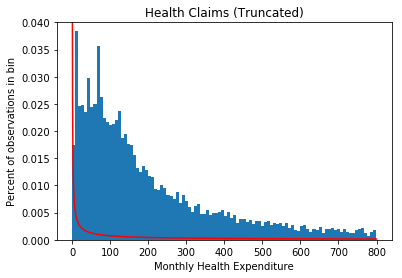

In [5]:
pts = np.linspace(1e-10, 800, 1600)
num_bins = 100
clms_trunc = clms[clms<800]
weights = (1 / clms.shape[0]) * np.ones_like(clms_trunc)
n, bin_cuts, patches = plt.hist(clms_trunc, num_bins, weights=weights)
plt.title('Health Claims (Truncated)', fontsize=12)
plt.xlabel('Monthly Health Expenditure')
plt.ylabel('Percent of observations in bin')
pdf_vals = gamma_pdf(pts, alpha_ga, beta_ga)
plt.plot(pts, pdf_vals, color='r')
plt.ylim([0, 0.040])
plt.show()

#### (c) Generalized gamma MLE

In [11]:
def gengamma_pdf(xvals, alpha, beta, m):
    G = math.gamma(alpha / m)
    pdf = (m / ((beta**alpha) * G)) * (xvals**(alpha - 1)) * (np.exp(-(xvals/beta) ** m))
    return pdf

def log_lik_gg(xvals, alpha, beta, m):
    pdf_vals = gengamma_pdf(xvals, alpha, beta, m)
    ln_pdf_vals = np.log(pdf_vals, where=(pdf_vals > 0))
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_gg(params, *args):
    alpha, beta, m = params
    xvals = args
    log_lik_val = log_lik_gg(xvals, alpha, beta, m)
    return -log_lik_val

beta_init = beta_MLE
alpha_init = alpha_MLE
m_init = 1
MLE_args = (clms)
params_init = np.array([alpha_init, beta_init, m_init])
results = opt.minimize(crit_gg, params_init, MLE_args, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None), (1e-10, None)))

alpha_gg, beta_gg, m_gg = results.x

print("alpha_MLE=", alpha_gg, "\nbeta_MLE=", beta_gg,
      "\nm_MLE=", m_gg,
      "\nLog likelihood=", log_lik_gg(clms, alpha_MLE, beta_MLE, m_MLE))

alpha_MLE= 0.221753917346 
beta_MLE= 21911.0642103 
m_MLE= 0.997647832773 
Log likelihood= -82076.4467958


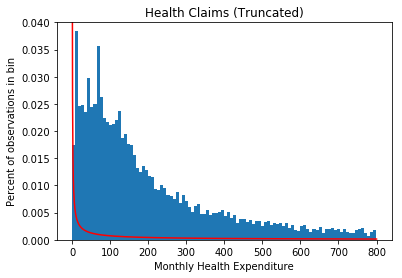

In [7]:
pts = np.linspace(1e-10, 800, 1600)
num_bins = 100
clms_trunc = clms[clms<800]
weights = (1 / clms.shape[0]) * np.ones_like(clms_trunc)
n, bin_cuts, patches = plt.hist(clms_trunc, num_bins, weights=weights)
plt.title('Health Claims (Truncated)', fontsize=12)
plt.xlabel('Monthly Health Expenditure')
plt.ylabel('Percent of observations in bin')
pdf_vals = gengamma_pdf(pts, alpha_MLE, beta_MLE, m_MLE)
plt.plot(pts, pdf_vals, color='r')
plt.ylim([0, 0.040])
plt.show()

#### (d) Generalized beta 2 MLE:

In [21]:
import scipy 

def beta2_pdf(xvals, a, b, p, q):
    B = scipy.special.beta(p, q)
    numer = a * (xvals ** ((a*p) - 1))
    denom = (b ** (a*p)) * B * ((1 + ((xvals / b)**a)) ** (p + q))
    return numer / denom

def log_lik_b2(xvals, a, b, p, q):
    pdf_vals = beta2_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals, where=(pdf_vals > 0))
    pdf_vals[np.isclose(pdf_vals, np.zeros_like(pdf_vals), atol=1e-25)] = 1e-10
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_b2(params, xvals):
    a, b, p, q = params
    log_lik_val = log_lik_b2(xvals, a, b, p, q)
    return -log_lik_val

a_init = m_MLE
q_init = 10000
b_init = (q_init ** (1 / m_MLE)) * beta_MLE
p_init = alpha_MLE / m_MLE

params_init = np.array([a_init, b_init, p_init, q_init])
results = opt.minimize(crit_b2, params_init, clms, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None), (1e-10, None),
                               (1e-10, None)))

a_MLE, b_MLE, p_MLE, q_MLE = results.x
print("a_MLE=", a_MLE, "\nb_MLE=", b_MLE,
      "\np_MLE=", p_MLE, "\nq_MLE=", q_MLE,
      "\nLog likelihood=", log_lik_b2(clms, a_MLE, b_MLE, p_MLE, q_MLE))

a_MLE= 0.702219922041 
b_MLE= 225115883.064 
p_MLE= 0.96277846421 
q_MLE= 9999.43281365 
Log likelihood= -76462.390441


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in power
//anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


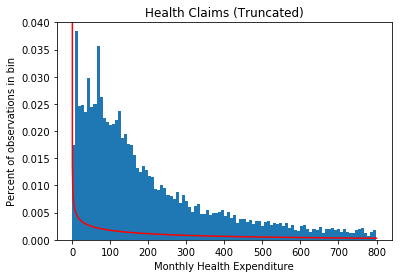

In [9]:
pts = np.linspace(1e-10, 800, 1600)
num_bins = 100
clms_trunc = clms[clms<800]
weights = (1 / clms.shape[0]) * np.ones_like(clms_trunc)
n, bin_cuts, patches = plt.hist(clms_trunc, num_bins, weights=weights)
plt.title('Health Claims (Truncated)', fontsize=12)
plt.xlabel('Monthly Health Expenditure')
plt.ylabel('Percent of observations in bin')
pdf_vals = beta2_pdf(pts, a_MLE, b_MLE, p_MLE, q_MLE)
plt.plot(pts, pdf_vals, color='r')
plt.ylim([0, 0.040])
plt.show()

#### (e) Likelihood ratio tests

In [20]:
log_lik_h0 = log_lik_b2(clms, a_MLE, b_MLE, p_MLE, q_MLE)

# testing gamma specification
log_lik_mle = log_lik_ga(clms, alpha_ga, beta_ga)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('p-value for gamma=', pval_h0)

# testing generalized gamma specification
log_lik_mle = log_lik_gg(clms, alpha_gg, beta_gg, m_gg)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('p-value for generalized gamma =', pval_h0)

p-value for gamma= 1.0
p-value for generalized gamma = 1.0


#### (f) 

In [19]:
pdf_beta2 = lambda x: beta2_pdf(x, a_MLE, b_MLE, p_MLE, q_MLE)
result = 1 - scipy.integrate.quad(pdf_beta2, 0, 1000)[0]
print("Probability of health claim > $1000 (GB2):", result)

pdf_ga = lambda x : gamma_pdf(x, alpha_ga, beta_ga)
result = 1 - scipy.integrate.quad(pdf_ga, 0, 1000)[0]
print("Probability of health claim > $1000 (GA):", result)


Probability of health claim > $1000 (GB2): 0.16505323005175732
Probability of health claim > $1000 (GA): 0.45195973837078673
